<a href="https://colab.research.google.com/github/salma71/blog_post/blob/master/bayesian_bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uncertainty estimates is essential for decision making. However, sometimes data scientists may ignore them due to pain to extract these estimates especially if the model is complicated, Random forest for instance. In this post, I will try to break that topic into small chunks for better understanding. The ultimate goal is to get a better bootstrap using the bayesian concept that you can use it more frequently with your models. So, let's get started. 

In [1]:
# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import dirichlet, norm, multinomial, gamma
from copy import deepcopy
from sklearn.utils import resample

# better plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('bmh')

Suppose we want to infer the posterior distribution over the mean of the following datapoint. 

You can simply do a resampling using bootstrap and take the mean over it. We generated a sample of 10,000 bootstrap to generate a resampling

In [6]:
test = np.array([1.6, 5.7, 0.7, 4.3, 2.0])
boot_test = [resample(test).mean() for _ in range(10000)]

To get better understanding, let's plot this bootstrap sampling to investigate the distribution 

Text(0.5, 1.0, 'Regular Bootstrapping')

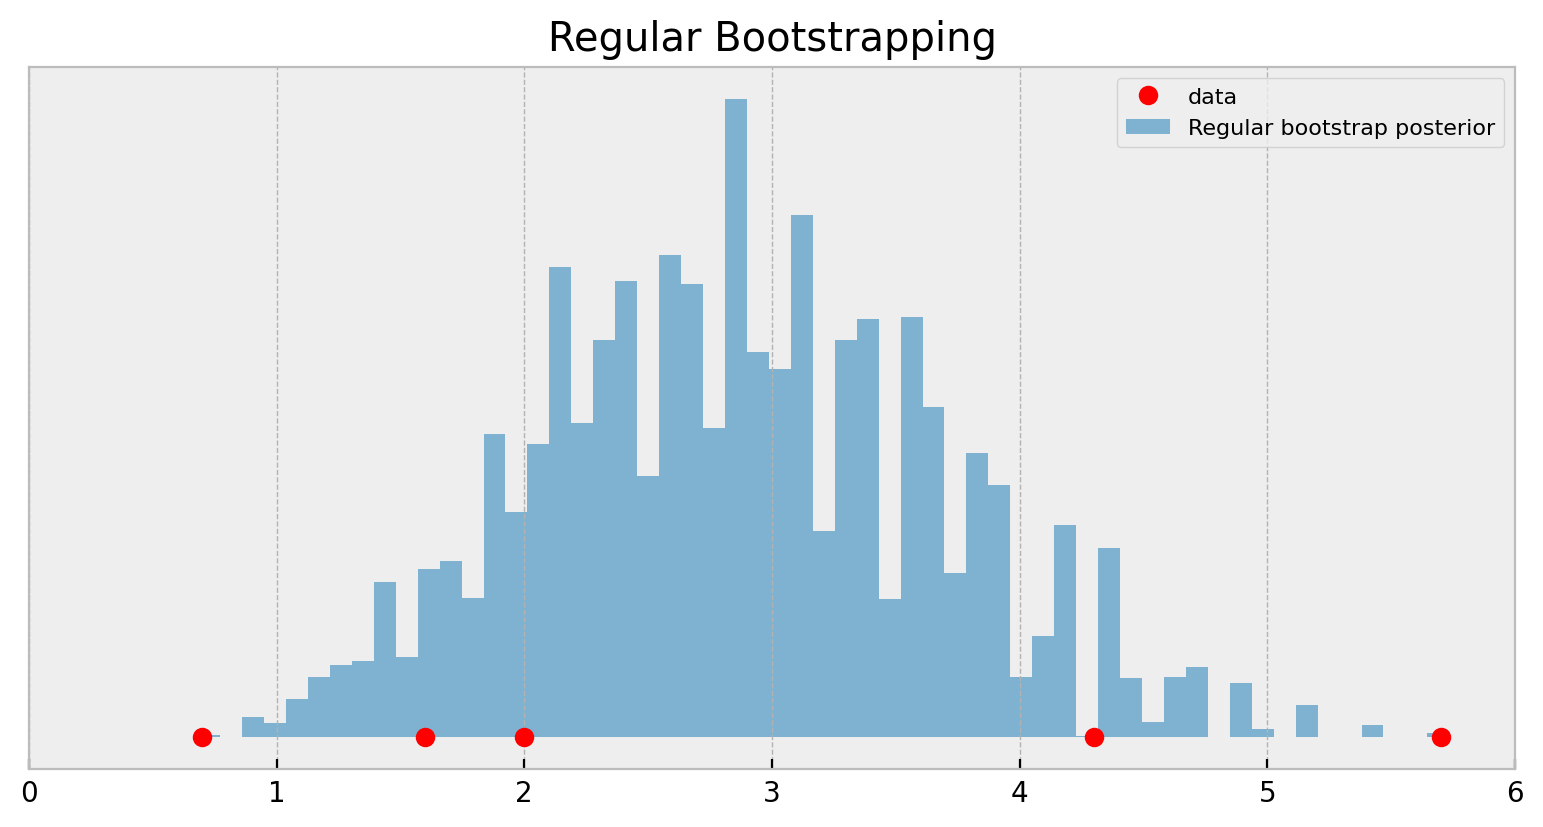

In [8]:
plt.figure(figsize=[8,4], dpi = 100)
h = plt.hist(
    boot_test, 
    alpha = 0.6,
    bins = np.linspace(-1, 6, 80),
    label = 'Regular bootstrap posterior',
    density = True
)
plt.plot(
    test,
    [0]*test.shape[0],
    'ro',
    label = 'data'
)

plt.tight_layout()
plt.legend(fontsize = 8)
plt.xlim(0, 6)
plt.ylim(bottom=-0.05*h[0].max())
plt.yticks([])
plt.title('Regular Bootstrapping')

So, we got a guassian normal distribution with 10,000 bootstrap resampling. However, as we see the edges are pretty rough, even when we increase the resampling size to the double, you can try it if you wish. 

A simple workaround to this issue is to use the baysian bootstrap. Fortunately, scipy has a nice class which can do this job for us `dirichlet()`. This is called the bayseian bootstrap and it gives you a posterior distribution which has a much smoother edges.

In [9]:
dirichlet_sample = dirichlet([1] * len(test)).rvs(10000)
bayes_boot = (test * dirichlet_sample).sum(axis = 1)

Text(0.5, 1.0, 'Bayesian Bootstrapping')

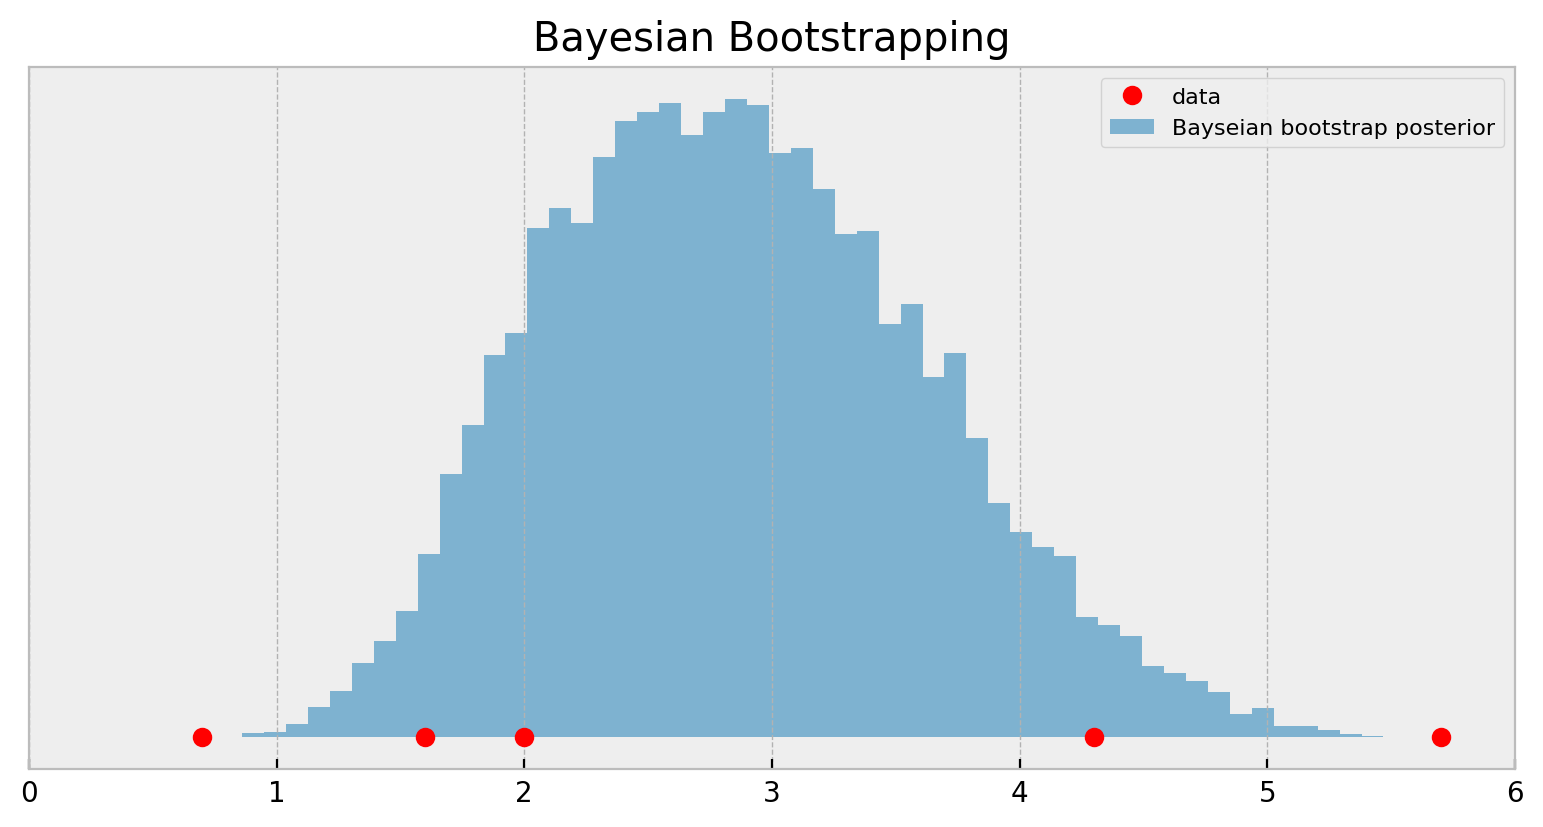

In [10]:
plt.figure(figsize=[8,4], dpi = 100)
h = plt.hist(
    bayes_boot, 
    alpha = 0.6,
    bins = np.linspace(-1, 6, 80),
    label = 'Bayseian bootstrap posterior',
    density = True
)
plt.plot(
    test,
    [0]*test.shape[0],
    'ro',
    label = 'data'
)

plt.tight_layout()
plt.legend(fontsize = 8)
plt.xlim(0, 6)
plt.ylim(bottom=-0.05*h[0].max())
plt.yticks([])
plt.title('Bayesian Bootstrapping')

now let's compare two distributions to see the difference.

Text(0.5, 1.0, 'Regular vs. Bayesian Bootstrapping')

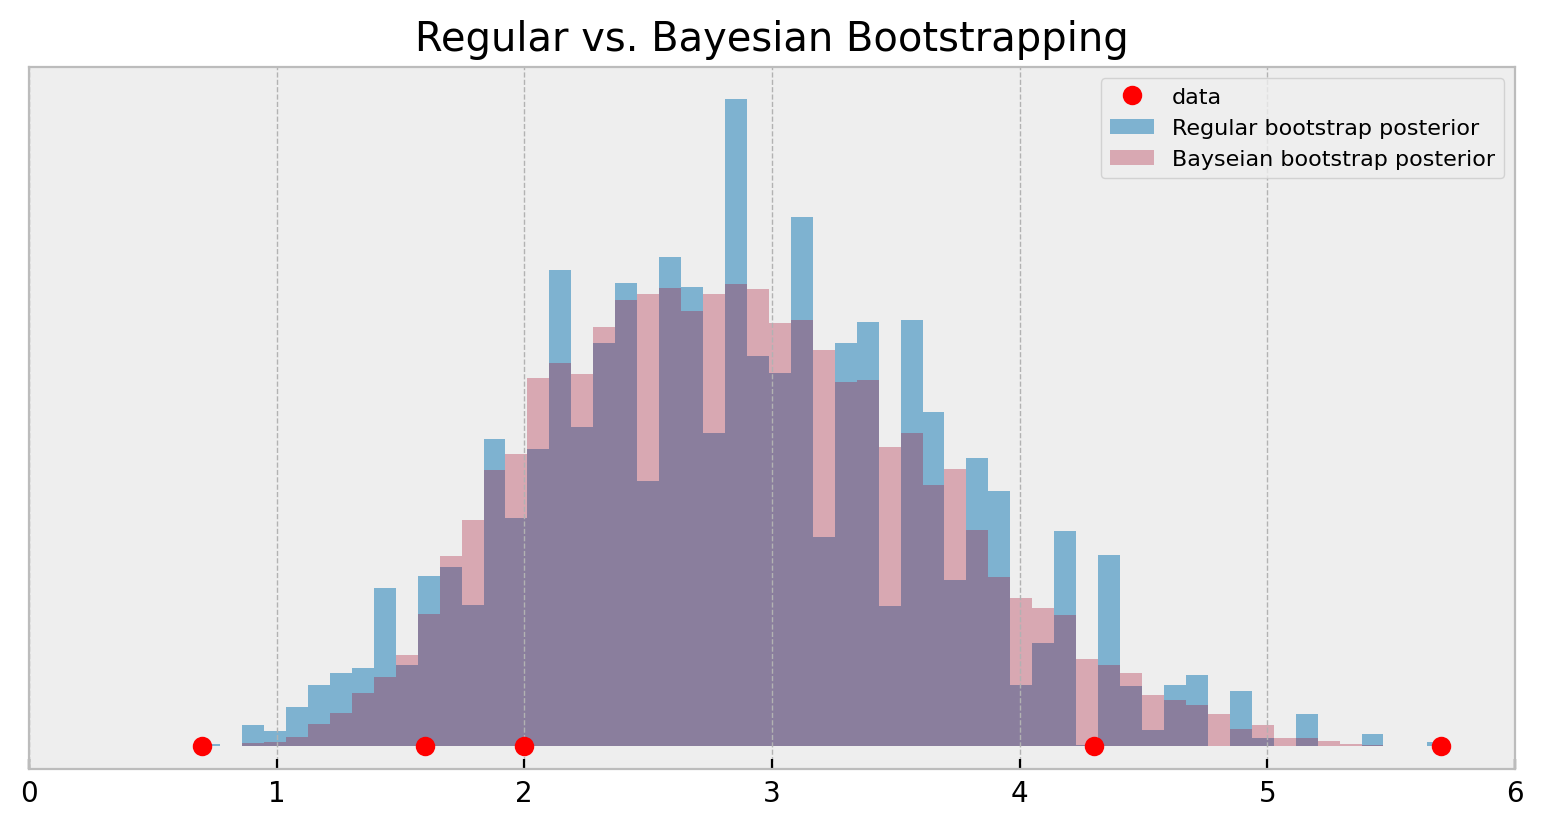

In [12]:
plt.figure(figsize=[8,4], dpi = 100)
h = plt.hist(
    boot_test, 
    alpha = 0.6,
    bins = np.linspace(-1, 6, 80),
    label = 'Regular bootstrap posterior',
    density = True
)
h = plt.hist(
    bayes_boot, 
    alpha = 0.3,
    bins = np.linspace(-1, 6, 80),
    label = 'Bayseian bootstrap posterior',
    density = True
)
plt.plot(
    test,
    [0]*test.shape[0],
    'ro',
    label = 'data'
)

plt.tight_layout()
plt.legend(fontsize = 8)
plt.xlim(0, 6)
plt.ylim(bottom=-0.05*h[0].max())
plt.yticks([])
plt.title('Regular vs. Bayesian Bootstrapping')

As we can see both graphs used the same exact data, so the question is, why we got a much smoother posterior when we used the Bayesian approach? To find out, we will estimate the posterior distribution over the mean of a gaussian as N(2, 1) and generate larger sets of points as we go to investigate the change.

> A deep copy constructs a new compound object and then, recursively, inserts copies into it of the objects found in the original.

In [35]:
np.random.seed(41)
sample_10 = np.random.normal(2, 1, size = 10)
sample_8 = deepcopy(sample_10[:8])
sample_6 = deepcopy(sample_10[:6])
sample_4 = deepcopy(sample_10[:3])

sample_list = [sample_10, sample_8, sample_6, sample_4]

since the posterior of a Gaussian prior given a Gaussian likelihood is also Gaussian. So, we can compare the bootstrap procedure confidently based on a reliable ground truth. 

In [36]:
# class for exact gaussian inference
class ExactGaussianInference:
    
    # initializing with prior paramters
    def __init__(self, prior_mu, prior_sigma, likelihood_sigma):
        
        # storing
        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma
        self.post_mu = prior_mu
        self.post_sigma = prior_sigma
        self.likelihood_sigma = likelihood_sigma
                
    # fitting the posterior for the mean
    def get_posterior(self, obs):
        
        # checking if there is any observation before proceeding
        if len(obs) > 0:
        
            # calculating needed statistics for the observations
            obs_mu = np.mean(obs)
            obs_sum = np.sum(obs)
            obs_n = len(obs)

            # updating posterior mean
            self.post_mu = (1/(1/self.prior_sigma**2 + obs_n/self.likelihood_sigma**2) *
                            (self.prior_mu/self.prior_sigma**2 + obs_sum/self.likelihood_sigma**2))

            # updating posterior sigma
            self.post_sigma = (1/self.prior_sigma**2 + obs_n/self.likelihood_sigma**2)**(-1)
            
        # return posterior
        return norm(self.post_mu, np.sqrt(self.post_sigma))

In [37]:
class BootstrapPosteriorInference:
    
    # initializing with prior paramters
    def __init__(self, n_draws):
        
        # storing
        self.n_draws = n_draws
                
    # fitting the posterior for the mean
    def get_posterior(self, obs):
        
        # checking if there is any observation before proceeding
        if len(obs) > 0:

          # running bootstrap samples
          boots_samples = np.array([resample(obs) for _ in range(self.n_draws)])
          posterior_draws = boots_samples.mean(axis=1)

          # return posterior density via samples
          return posterior_draws

        else:
          print('Cannot run with no observations!')
          raise

In [38]:
# class for exact gaussian inference
class BayesianBootstrapPosteriorInference:
    
    # initializing with prior paramters
    def __init__(self, n_draws):
        
        # storing
        self.n_draws = n_draws
                
    # fitting the posterior for the mean
    def get_posterior(self, obs):
        
        # checking if there is any observation before proceeding
        if len(obs) > 0:

          # running bootstrap samples
          dir_samples = dirichlet([1] * len(obs)).rvs(self.n_draws)
          posterior_draws = (dir_samples * obs).sum(axis=1)

          # return posterior density via samples
          return posterior_draws

        else:
          print('Cannot run with no observations!')
          raise

In [39]:
# configuring exact posterior
egi = ExactGaussianInference(0, 100, 1)

# calculating posteriors
exact_post_list = []
for sample in sample_list:
  exact_post_list.append(egi.get_posterior(sample))

In [40]:
# configuring bootstrap posterior
bpi = BootstrapPosteriorInference(10000)

# calculating posteriors
boots_post_list = []
for sample in sample_list:
  boots_post_list.append(bpi.get_posterior(sample))

In [41]:
def figure(figsize=None):
    'Temporary workaround for traditional figure behaviour with the ipympl widget backend'
    fig = plt.figure()
    if figsize:
        w, h =  figsize
    else:
        w, h = plt.rcParams['figure.figsize']
    fig.canvas.layout.height = str(h) + 'in'
    fig.canvas.layout.width = str(w) + 'in'
    return fig

In [42]:
def plot_fig_1():

  for i in range(4):

    post = exact_post_list[i]
    sample = sample_list[i]

    plt.subplot(2, 4, i+1)
    plt.fill_between(x_grid, post.pdf(x_grid), alpha=0.5, label='exact\nposterior')
    plt.plot(sample, [0]*sample.shape[0], 'ro', label='data')
    plt.tight_layout()
    plt.legend(fontsize=8)
    plt.xlim(-1, 5)
    plt.ylim(bottom=-0.05*post.pdf(x_grid).max())
    plt.yticks([])
    plt.title(f'Exact, N = {sample.shape[0]}')

  for i in range(4):

    post = boots_post_list[i]
    sample = sample_list[i]

    plt.subplot(2, 4, i+5)
    h = plt.hist(post, alpha=0.5, bins = np.linspace(-1, 5, 80), label='bootstrap\nposterior', density=True)
    plt.plot(sample, [0]*sample.shape[0], 'ro', label='data')
    plt.tight_layout()
    plt.legend(fontsize=8)
    plt.xlim(-1, 5)
    plt.ylim(bottom=-0.05*h[0].max())
    plt.yticks([])
    plt.title(f'Classic Bootstrap, N = {sample.shape[0]}')

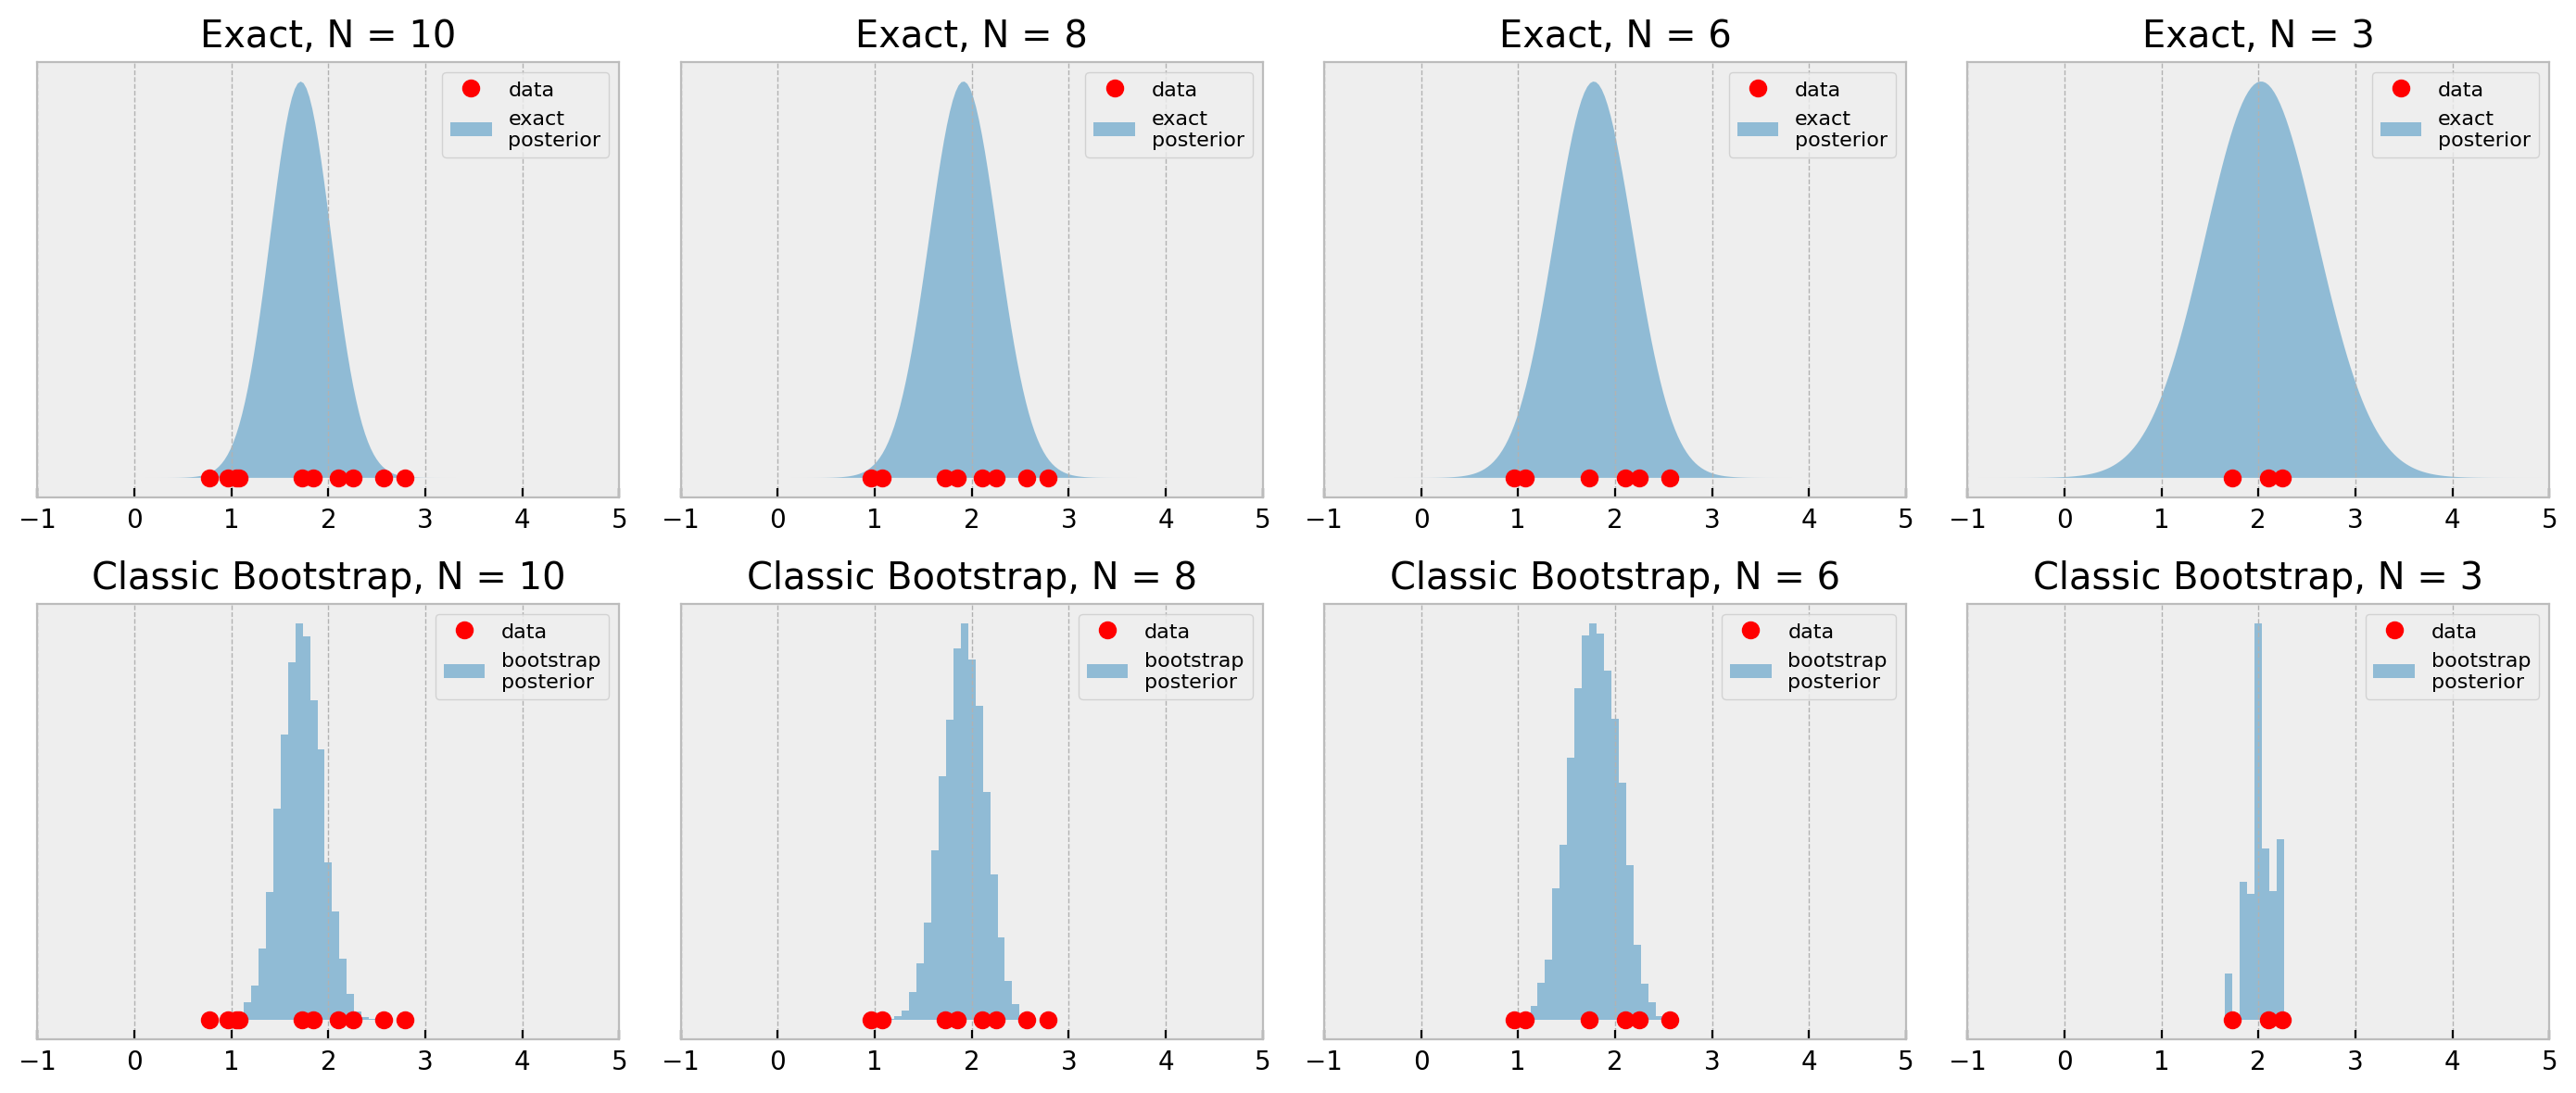

In [43]:
# grid for plotting pdf
x_grid = np.linspace(-1, 5, 200)

# opening figure
plt.figure(figsize=[14,6], dpi=100)

# plotting
plot_fig_1()

As we can see, then the N increases, the smoothness of the posterior probabilty increases. N = 10 has a smoother edges than N = 3. However, we can improve that to even better performance.

# Bootstrap as multinomial weighted sum of samples

Suppose we have the following sample of `[1, 2, 3]` and we want to draw a sample out of it after bootstraping

In [56]:
np.random.seed(41) 
a = [1, 2, 3]

for _ in range(5):
  res_a = resample(a)
  print(f'resampled array: {sorted(res_a)}, bootstrap_average = {np.mean(res_a): .2f}')

resampled array: [1, 1, 3], bootstrap_average =  1.67
resampled array: [1, 2, 2], bootstrap_average =  1.67
resampled array: [2, 2, 3], bootstrap_average =  2.33
resampled array: [1, 1, 3], bootstrap_average =  1.67
resampled array: [1, 1, 3], bootstrap_average =  1.67


In [57]:
np.random.seed(41) 

a = [1, 2, 3]

for _ in range(5):
  res_a = resample(a)
  counter = [(np.array(res_a) == k).sum() for k in sorted(a)]
  print(f'Resampled array: {sorted(res_a)}, counter array: {counter}, bootstrap_average = {np.mean(res_a): .2f}')

Resampled array: [1, 1, 3], counter array: [2, 0, 1], bootstrap_average =  1.67
Resampled array: [1, 2, 2], counter array: [1, 2, 0], bootstrap_average =  1.67
Resampled array: [2, 2, 3], counter array: [0, 2, 1], bootstrap_average =  2.33
Resampled array: [1, 1, 3], counter array: [2, 0, 1], bootstrap_average =  1.67
Resampled array: [1, 1, 3], counter array: [2, 0, 1], bootstrap_average =  1.67


Now, we will draw from a multinomial distribution with size of N and 1/N probabilities.

In [58]:
np.random.seed(41)
multinom_sample = multinomial(len(a), [1./len(a)] * len(a)).rvs(5)
print(f'Multinomial samples: \n{multinom_sample}')

Multinomial samples: 
[[0 0 3]
 [1 0 2]
 [0 2 1]
 [0 2 1]
 [2 0 1]]


Now it might be possible to calculate the bootstrap average as a weighted sum of samples, where it drawn from a multinomial distribution 

In [61]:
np.random.seed(41)
multinom_sample = multinomial(len(a), [1./len(a)] * len(a), seed = 41).rvs(5)
boot_avg = (multinom_sample * np.array(a)).sum(axis = 1) * 1 / len(a)

print(f'Multinomial samples: \n {multinom_sample}, \nbootstrape_avg: \n{boot_avg}')

Multinomial samples: 
 [[0 0 3]
 [1 0 2]
 [0 2 1]
 [0 2 1]
 [2 0 1]], 
bootstrape_avg: 
[3.         2.33333333 2.33333333 2.33333333 1.66666667]


We need to reshape the bootstrap_avg to the same original `a` array shape which is `2D` array. To do so, we will make use of `np.reshape()` method. First, we flatten the array then we will construct the 2 D array with only one element per column `.reshape(-1, 1)`

In [62]:
np.random.seed(41)
multinom_sample = multinomial(len(a), [1./len(a)] * len(a), seed = 41).rvs(5)
boot_avg = (multinom_sample * np.array(a)).sum(axis = 1) * 1 / len(a)

print(f'Multinomial samples: \n {multinom_sample}, \nbootstrape_avg: \n{boot_avg.reshape(-1, 1)}')

Multinomial samples: 
 [[0 0 3]
 [1 0 2]
 [0 2 1]
 [0 2 1]
 [2 0 1]], 
bootstrape_avg: 
[[3.        ]
 [2.33333333]
 [2.33333333]
 [2.33333333]
 [1.66666667]]


Great, we came up with a vectorized implementation of the bootstrap procedure. However, if you noticed, the `boot_avg` vector has some discrete values which would make the distribution less smooth. 

To improve the distribution, we can do normalization to the imput sample, so we can only get values between 0 and 1. 

In [63]:
np.random.seed(41)
multinom_sample = multinomial(len(a), [1./len(a)] * len(a)).rvs(5) * 1/ len(a)
print(f'Multinomial sample: \n{multinom_sample}')

Multinomial sample: 
[[0.         0.         1.        ]
 [0.33333333 0.         0.66666667]
 [0.         0.66666667 0.33333333]
 [0.         0.66666667 0.33333333]
 [0.66666667 0.         0.33333333]]


Also, we can instead use the `dirichlet()` method within the `scipy` package to generate a normalized sample with values between 0 and 1 but it is not restricted to a defined set of propotions like multinomial distribution. That's would give us a smoother distribution when we try to calculate boot_avg.  

In [64]:
np.random.seed(41)

dirich_sample = dirichlet([1] * len(a)).rvs(5)
print(f'Dirichlet sample: \n{dirich_sample}')

Dirichlet sample: 
[[0.19712495 0.03219893 0.77067612]
 [0.04061569 0.11311929 0.84626502]
 [0.05560369 0.28978149 0.65461482]
 [0.42418889 0.31570783 0.26010328]
 [0.16574339 0.30667348 0.52758314]]


In [65]:
np.random.seed(41)

dirich_sample = dirichlet([1] * len(a)).rvs(5)
boot_avg = (dirich_sample * np.array(a)).sum(axis = 1)
print(f'Dirichlet sample: \n{dirich_sample}, \nbootstrap_avg: \n{boot_avg.reshape(-1, 1)}')

Dirichlet sample: 
[[0.19712495 0.03219893 0.77067612]
 [0.04061569 0.11311929 0.84626502]
 [0.05560369 0.28978149 0.65461482]
 [0.42418889 0.31570783 0.26010328]
 [0.16574339 0.30667348 0.52758314]], 
bootstrap_avg: 
[[2.57355117]
 [2.80564933]
 [2.59901113]
 [1.83591438]
 [2.36183975]]


Great we got a more smoother values using bayesian bootstrap. To see this in action let's compare the three methods together using `matlibplot`

In [66]:
# configuring bayesian bootstrap posterior
bbpi = BayesianBootstrapPosteriorInference(10000)

# calculating posteriors
bayesboots_post_list = []
for sample in sample_list:
  bayesboots_post_list.append(bbpi.get_posterior(sample))

In [67]:
def plot_fig_2():

  for i in range(4):

    post = exact_post_list[i]
    sample = sample_list[i]

    plt.subplot(3, 4, i+1)
    plt.fill_between(x_grid, post.pdf(x_grid), alpha=0.5, label='exact\nposterior')
    plt.plot(sample, [0]*sample.shape[0], 'ro', label='data')
    plt.tight_layout()
    plt.legend(fontsize=8)
    plt.xlim(-1, 5)
    plt.ylim(bottom=-0.05*post.pdf(x_grid).max())
    plt.yticks([])
    plt.title(f'Exact, N = {sample.shape[0]}')

  for i in range(4):

    post = boots_post_list[i]
    sample = sample_list[i]

    plt.subplot(3, 4, i+5)
    h = plt.hist(post, alpha=0.5, bins = np.linspace(-1, 5, 80), label='bootstrap\nposterior', density=True)
    plt.plot(sample, [0]*sample.shape[0], 'ro', label='data')
    plt.tight_layout()
    plt.legend(fontsize=8)
    plt.xlim(-1, 5)
    plt.ylim(bottom=-0.05*h[0].max())
    plt.yticks([])
    plt.title(f'Classic Bootstrap, N = {sample.shape[0]}')

  for i in range(4):

    post = bayesboots_post_list[i]
    sample = sample_list[i]

    plt.subplot(3, 4, i+9)
    h = plt.hist(post, alpha=0.5, bins = np.linspace(-1, 5, 80), label='bayesian\nbootstrap\nposterior', density=True)
    plt.plot(sample, [0]*sample.shape[0], 'ro', label='data')
    plt.tight_layout()
    plt.legend(fontsize=8)
    plt.xlim(-1, 5)
    plt.ylim(bottom=-0.05*h[0].max())
    plt.yticks([])
    plt.title(f'Bayesian Bootstrap, N = {sample.shape[0]}')

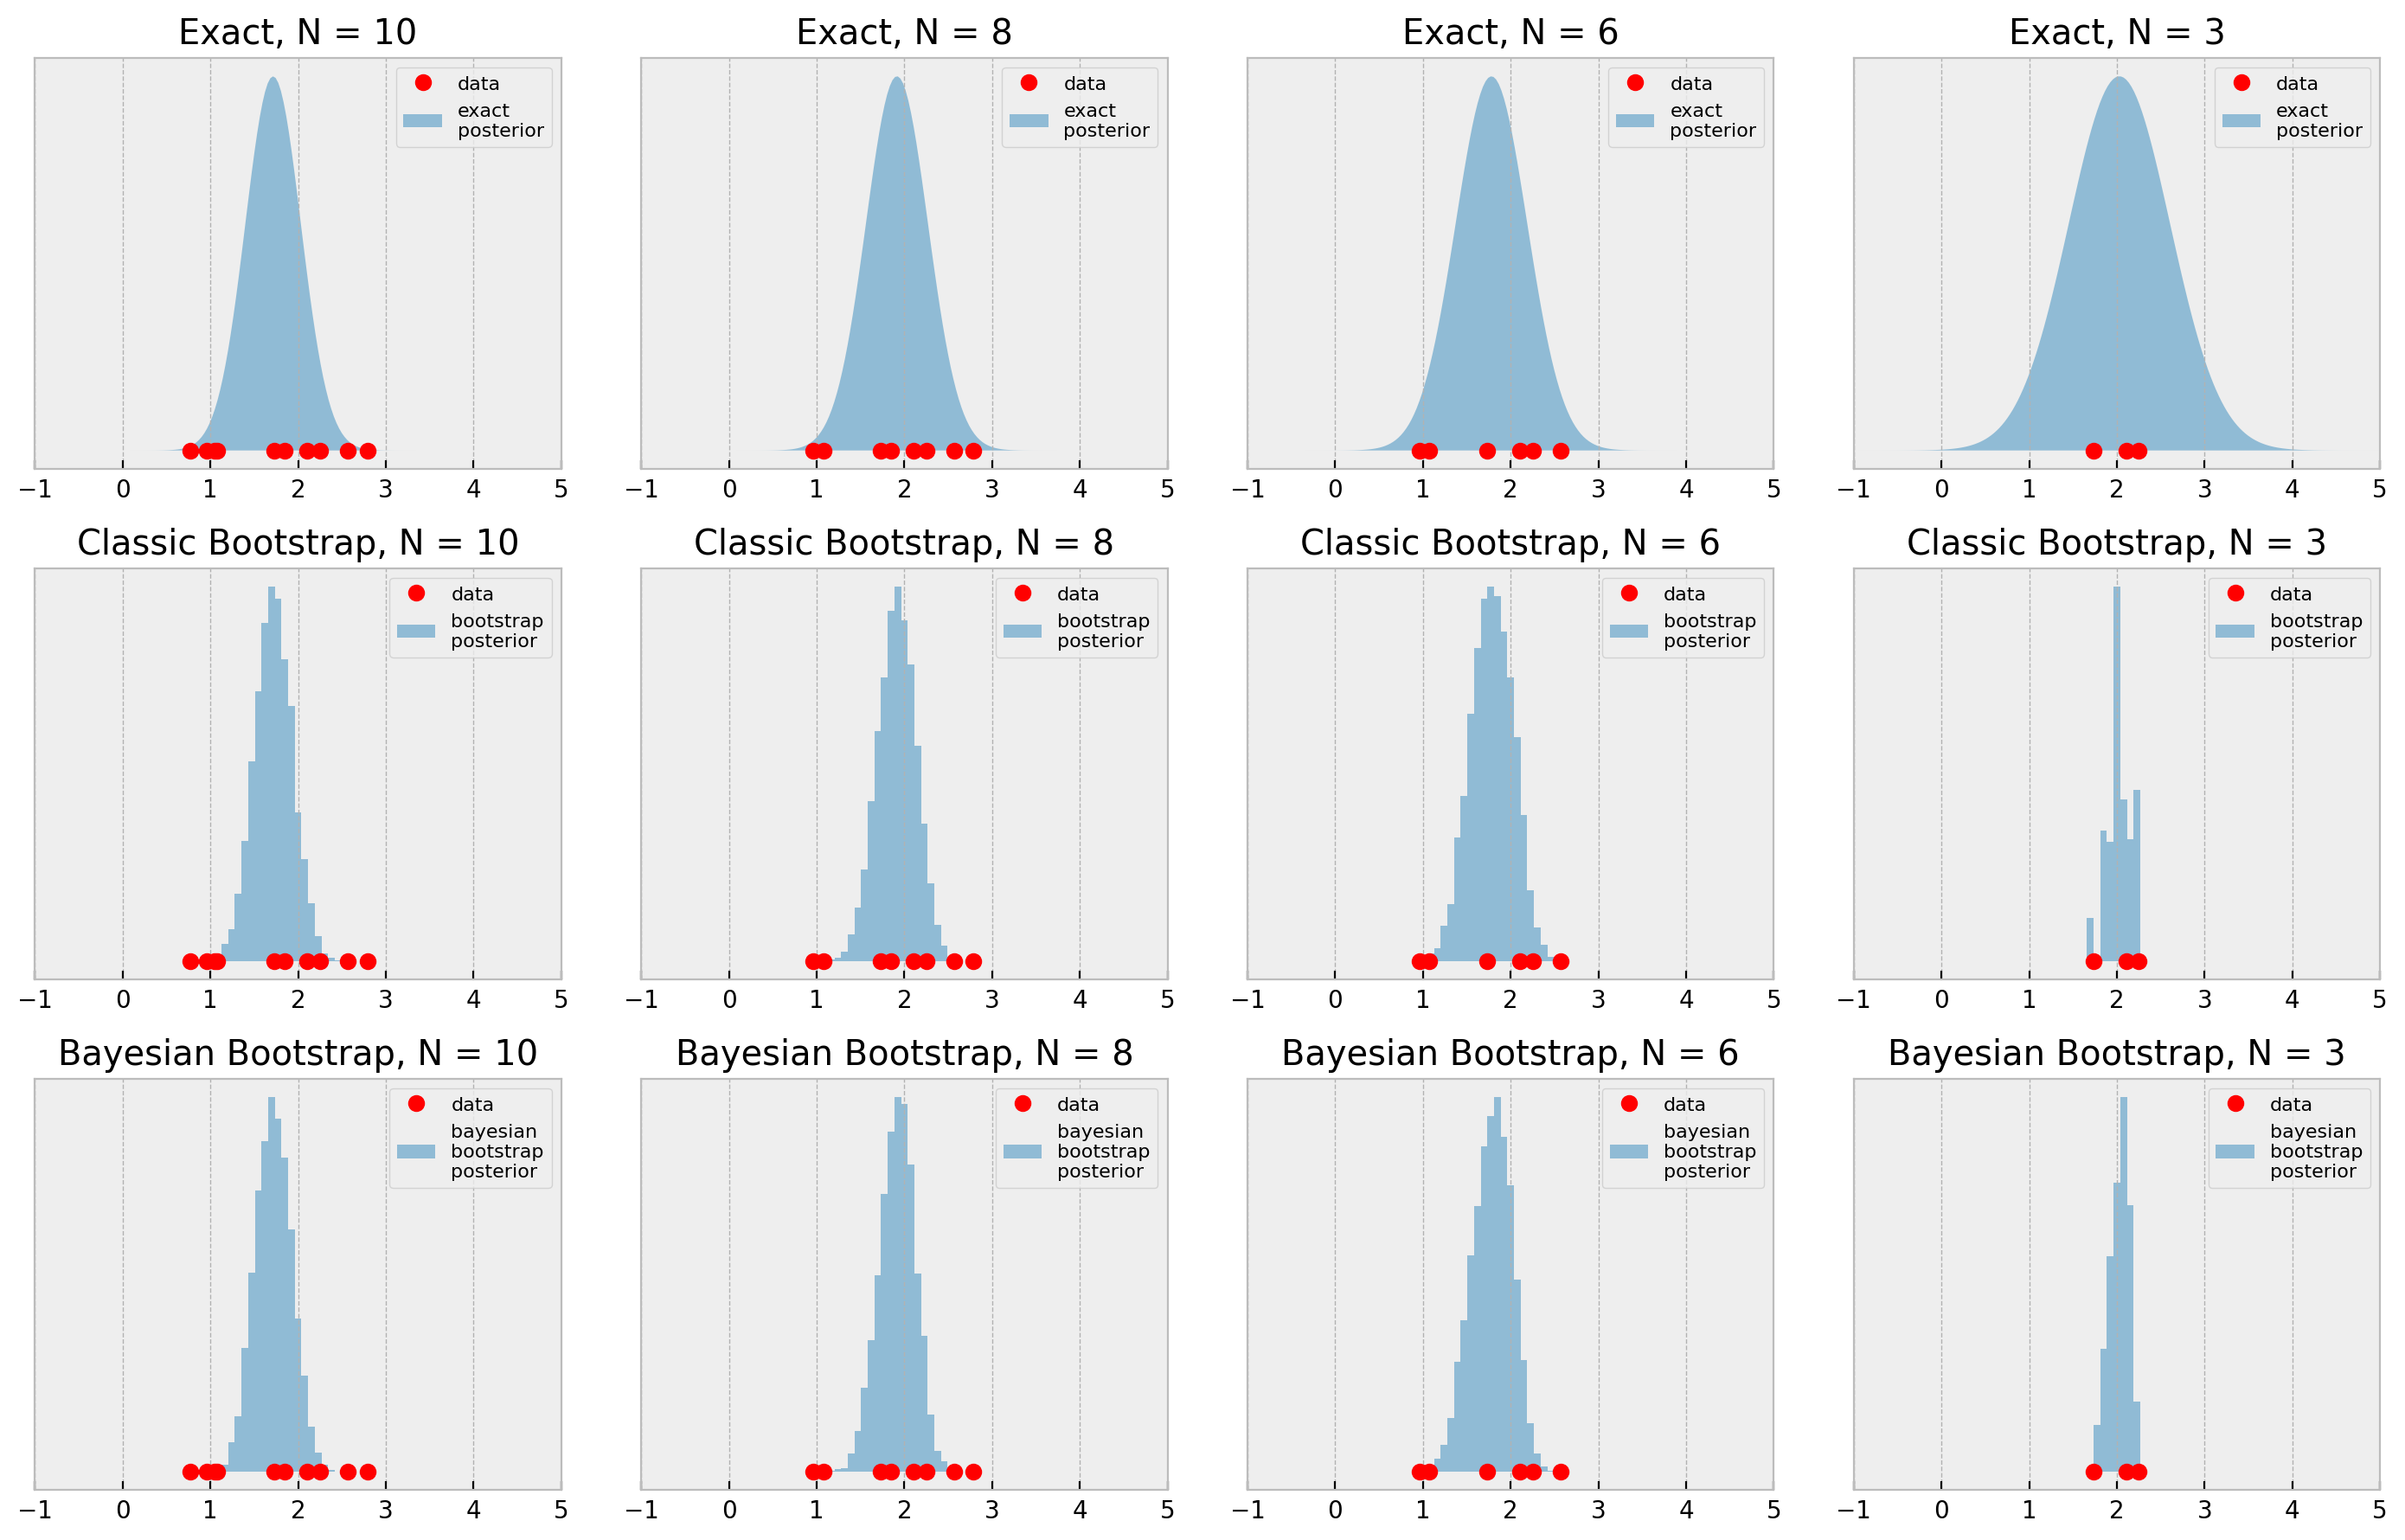

In [68]:
# grid for plotting pdf
x_grid = np.linspace(-1, 5, 200)

# opening figure
plt.figure(figsize=[14,9], dpi=100)

# plotting
plot_fig_2()

Awesome, We implemented the Bayesian bootstrap to get a smoother version of the regular bootstrap version. If you want to get deeper into the intuition, I highly recommend [this article](http://www.sumsar.net/blog/2015/04/the-non-parametric-bootstrap-as-a-bayesian-model/) by Rasmus Bååth which demonestrate a more in-depth interpretation of this approach. 